In [38]:
import matplotlib.pyplot as plt


In [39]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random as rnd
import pandas as pd
import numpy as np
import pickle
import cv2
import os


class CustomDataset(Dataset):
    def __init__(
        self,
        csv_file,
        root_dir,
        save_file=None,
        transform=None,
        mask_dir=None,
        have_mask=False,
    ):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.save_file = save_file
        self.transform = transform
        self.have_mask = have_mask
        self.mask_dir = mask_dir

        if not save_file:
            return

        if os.path.exists(self.save_file):
            with open(self.save_file, "rb") as f:
                self.data = pickle.load(f)
        else:
            self.data = []
            for idx in range(len(self.data_frame)):
                img_name = os.path.join(
                    self.root_dir, f"img_{self.data_frame.iloc[idx, 0]}.png"
                )
                image = Image.open(img_name)
                target = self.data_frame.iloc[idx, 1]

                if self.have_mask:
                    mask_name = os.path.join(
                        self.mask_dir, f"img_{self.data_frame.iloc[idx, 0]}.png"
                    )
                    mask = Image.open(mask_name)
                    image = Image.fromarray(
                        cv2.bitwise_and(
                            np.array(image), np.array(image), mask=np.array(mask)
                        )
                    )

                if self.transform:
                    image = self.transform(image)

                self.data.append((image, target))

            # Сохраняем данные в файл
            with open(self.save_file, "wb") as f:
                pickle.dump(self.data, f)

    def __len__(self):
        return 200

        if self.save_file:
            return len(self.data)
        return len(self.data_frame)

    def __getitem__(self, idx):
        if self.save_file:
            return self.data[idx]
        
        img_name = os.path.join(self.root_dir, f"img_{self.data_frame.iloc[idx, 0]}.png")
        image = Image.open(img_name)
        target = self.data_frame.iloc[idx, 1]

        if self.have_mask:
            mask_name = os.path.join(self.mask_dir, f"img_{self.data_frame.iloc[idx, 0]}.png")
            mask = Image.open(mask_name)
            image = Image.fromarray(cv2.bitwise_and(np.array(image), np.array(image), mask=np.array(mask)))

        if self.transform:
            image = self.transform(image)

        return image, target

    def get_balance_data(self, augmentation_transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45)
    ])):
        class_count = {}
        balance_data = []

        for i in range(len(self)):
            if self[i][1] not in class_count.keys():
                class_count[self[i][1]] = [1, [i]]
            else:
                class_count[self[i][1]] = [class_count[self[i][1]][0] + 1, class_count[self[i][1]][1] + [i]]
                balance_data.append(self[i])

        mx_count = max(class_count.items(), key=lambda x:x[1][0])

        for item in class_count.items():
            for _ in range(mx_count[1][0] - item[1][0]):
                x = rnd.choice(item[1][1])
                image = self[x][0]
                balance_data.append((augmentation_transform(image), self[x][1]))
        return balance_data



In [40]:
csv_file = os.getcwd() + '\\data\\train_answers.csv'
root_dir = os.getcwd() + '\\data\\train_images'
mask_dir = os.getcwd() + '\\data\\train_lung_masks'
save_file = os.getcwd() + '\\data\\data.pkl'

# Преобразования изображений
transform = transforms.Compose([
    transforms.ToTensor()
])

In [41]:
dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, mask_dir=mask_dir, transform=transform, have_mask=True)

200


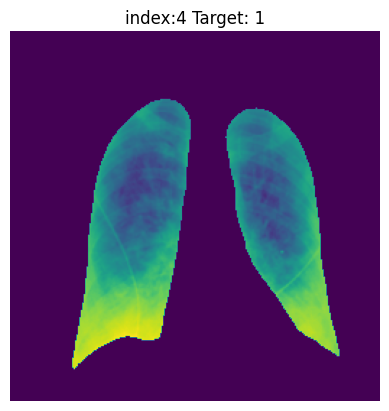

In [42]:
display_transform = transforms.Compose([
    transforms.ToPILImage()
])

# Вывод изображения из датасета
idx = 4  # Индекс изображения, которое вы хотите отобразить
sample = dataset[idx]
masked_image, target = sample

# Применение преобразования для отображения
display_image = display_transform(masked_image)
print(len(dataset))

# Отображение изображения
plt.imshow(display_image)
plt.title(f"index:{idx} Target: {target}")
plt.axis('off')  # Убрать оси координат
plt.show()


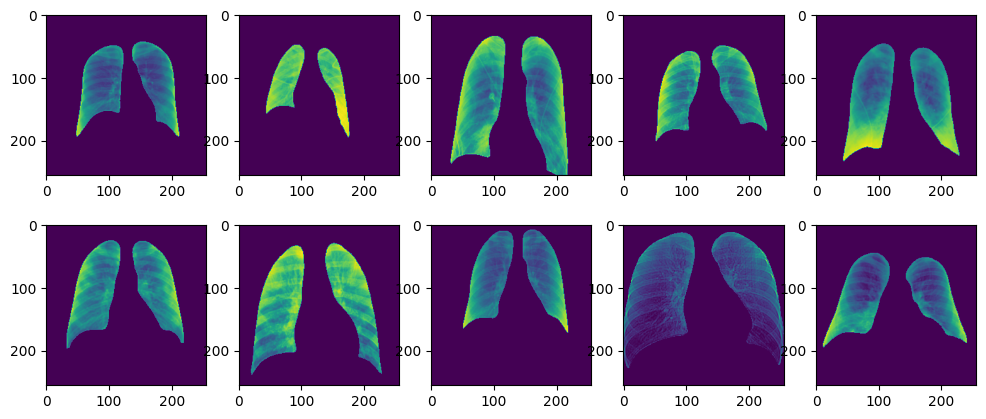

In [43]:
plt.figure(figsize=(12, 5))

one = [dataset[i] for i in range(5)]
two = [dataset[i] for i in range(5, 10)]


x, f = [one, two], 0
for i in range(10):
    if i > 4:
        f = 1
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.transpose(x[f][i % 5][0].detach().cpu().numpy(), (1, 2, 0)))

plt.show()


In [44]:
balace_data = dataset.get_balance_data()
print('ok')

ok
